<a href="https://colab.research.google.com/github/weicap/MCC_Vision_Artificial/blob/main/practica_1/practica_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt

## ZOOM - interpolacion bilineal

In [117]:
url_zoom = 'https://ii.ct-stc.com/3/logos/candidates/2017/06/08/bachiller-en-ing-industrial-3D868647D4592921023824thumbnail.jpeg'

In [118]:
image = io.imread(url_zoom) 
image = cv.cvtColor(image,cv.COLOR_BGR2RGB)

In [119]:
# INTERPOLACION BILINEAL

def zoom_bilinear(img, zoom_factor):
    height, width = img.shape[:2]
    new_height = int(height * zoom_factor)
    new_width = int(width * zoom_factor)
    new_img = np.zeros((new_height, new_width, 3), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            x = int(i / zoom_factor)
            y = int(j / zoom_factor)
            if x >= height - 1 or y >= width - 1:
                continue
            a = i / zoom_factor - x
            b = j / zoom_factor - y
            new_img[i, j] = (1 - a) * (1 - b) * img[x, y] + \
                            (1 - a) * b * img[x, y+1] + \
                            a * (1 - b) * img[x+1, y] + \
                            a * b * img[x+1, y+1]

    return new_img


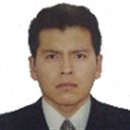

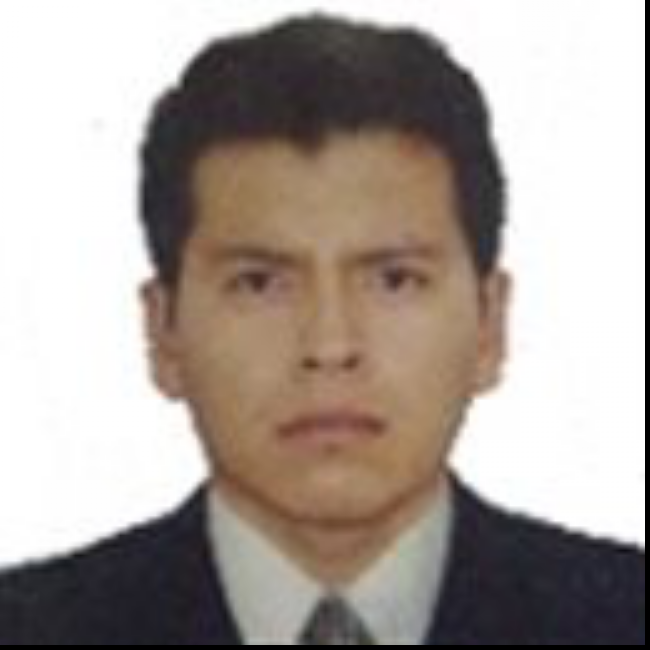

In [120]:
zoomed_img = zoom_bilinear(image, 5)
#final_frame = cv.hconcat((image,zoomed_img))
cv2_imshow(image)
cv2_imshow(zoomed_img)


## BICUBIC

In [59]:

def cubic_interpolation(x, y, v):
    P = np.array([
        [1, x, x**2, x**3],
        [0, 1, 2*x, 3*x**2],
        [0, 0, 2, 6*x],
        [0, 0, 0, 6]
    ])
    a = np.linalg.inv(P).dot(v)
    return a[0] + a[1]*y + a[2]*y**2 + a[3]*y**3

def zoom_bicubic(img, zoom_factor):
    height, width = img.shape[:2]
    new_height = int(height * zoom_factor)
    new_width = int(width * zoom_factor)
    new_img = np.zeros((new_height, new_width, 3), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            x = i / zoom_factor
            y = j / zoom_factor
            if x >= height - 3 or y >= width - 3:
                continue
            x_floor = int(np.floor(x))
            y_floor = int(np.floor(y))
            v = np.zeros((4, 4, 3))
            for k in range(4):
                for l in range(4):
                    v[k, l] = img[x_floor+k, y_floor+l]
            new_img[i, j] = [
                cubic_interpolation(x % 1, y % 1, v[:, :, 0]),
                cubic_interpolation(x % 1, y % 1, v[:, :, 1]),
                cubic_interpolation(x % 1, y % 1, v[:, :, 2])
            ]

    return new_img

In [ ]:
zoomed_img_cubic = zoom_bicubic(image,5)
cv2_imshow(zoomed_img_cubic)

## CONVULUCION

In [94]:
url_conv = 'https://iiif.lib.ncsu.edu/iiif/0016007/full/800,/0/default.jpg'
image_conv = io.imread(url_conv) 
image_conv = cv.cvtColor(image_conv,cv.COLOR_BGR2RGB)

In [95]:

def convolve(image, kernel):
    # Obtener las dimensiones de la imagen y el kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Inicializar la imagen resultante
    result = np.zeros_like(image)

    # Realizar la convolución
    for i in range(image_height - kernel_height + 1):
        for j in range(image_width - kernel_width + 1):
            result[i, j] = np.sum(image[i:i+kernel_height, j:j+kernel_width] * kernel)

    return result

In [96]:
# Definir el kernel
kernel = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])


In [97]:
image_gray = cv.cvtColor(image_conv, cv.COLOR_BGR2GRAY)

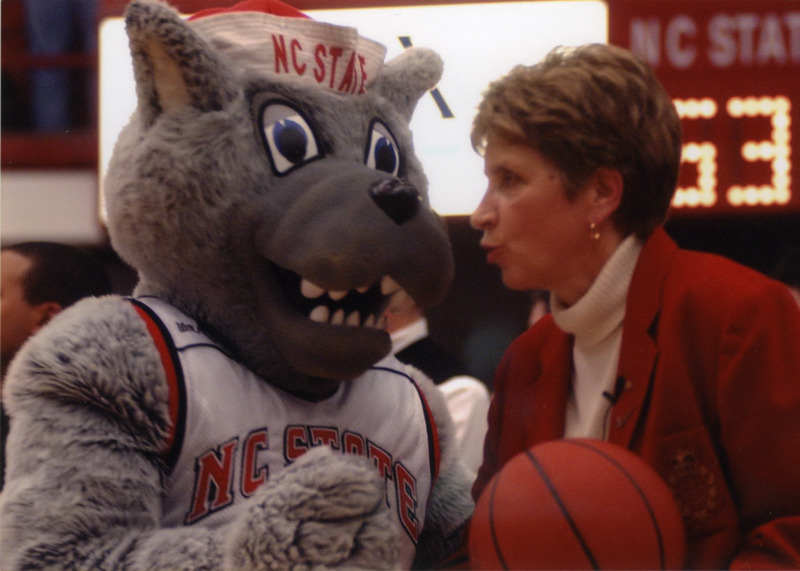

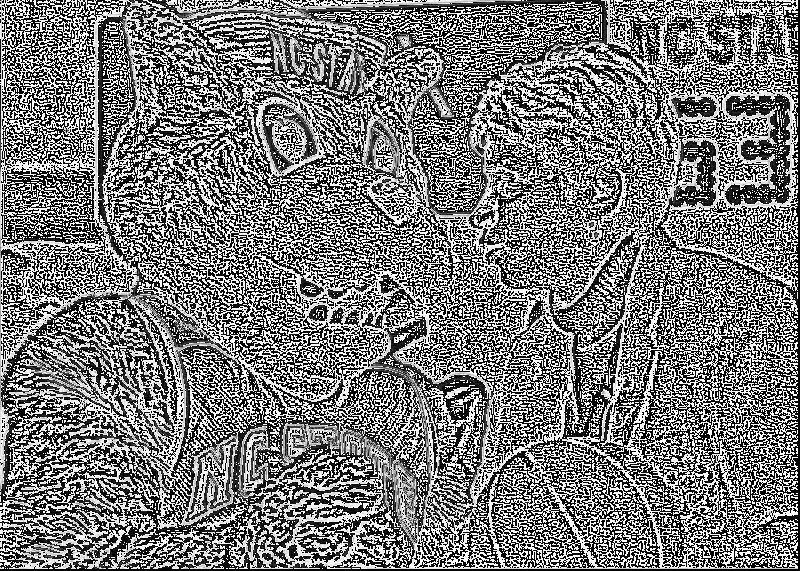

In [98]:
# Realizar la convolución
result = convolve(image_gray, kernel)
cv2_imshow(image_conv)
cv2_imshow(result)

## COMBINACION DE IMAGENES

### SUMA

In [132]:
url1 = 'https://iiif.lib.ncsu.edu/iiif/0052574/full/800,/0/default.jpg'
url2 = 'https://iiif.lib.ncsu.edu/iiif/0016007/full/800,/0/default.jpg'

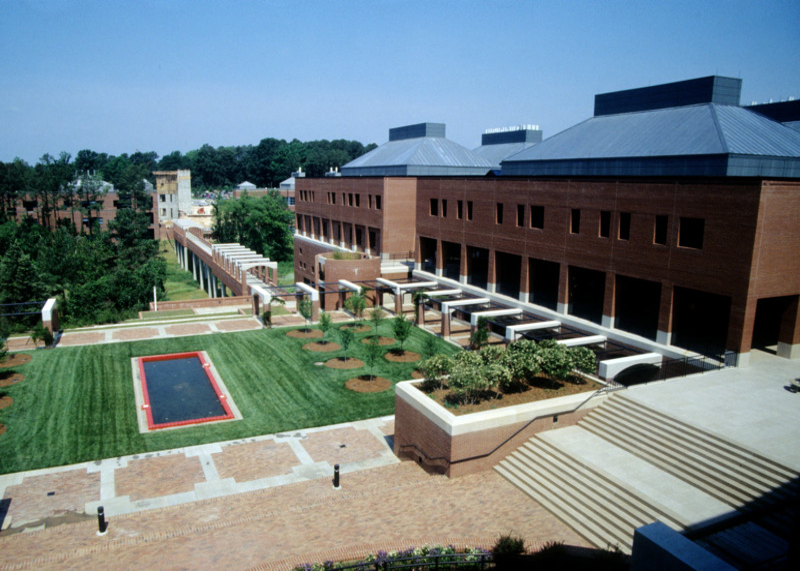

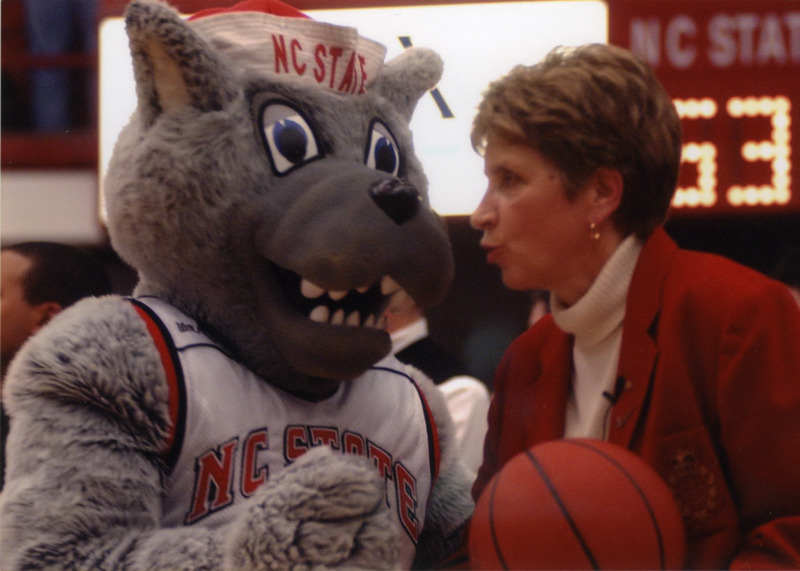

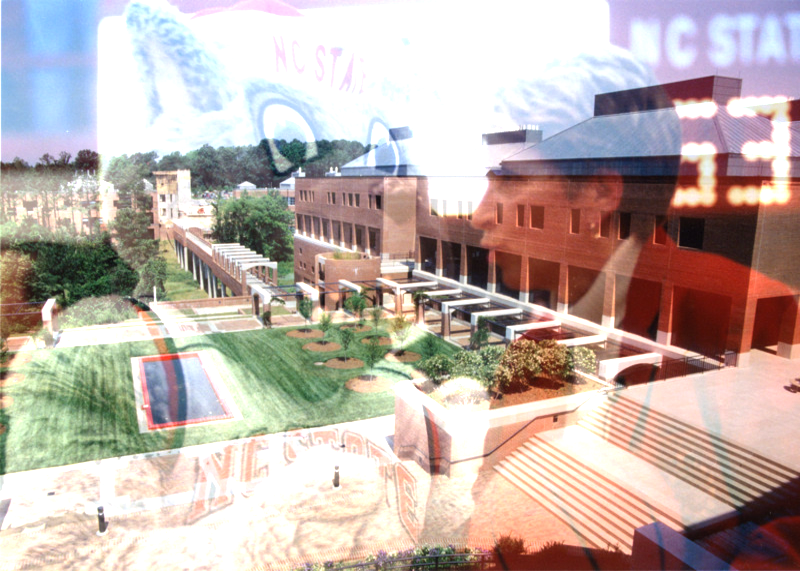

In [133]:
import requests
from PIL import Image
from io import BytesIO

# Descargar y cargar las dos imágenes desde URL
# url1 = 'https://iiif.lib.ncsu.edu/iiif/0052574/full/800,/0/default.jpg'
# url2 = 'https://iiif.lib.ncsu.edu/iiif/0016007/full/800,/0/default.jpg'
response1 = requests.get(url1)
response2 = requests.get(url2)
img1 = Image.open(BytesIO(response1.content))
img2 = Image.open(BytesIO(response2.content))

# Asegurarse de que ambas imágenes tengan el mismo tamaño
img1 = img1.resize((img2.width, img2.height))

# Sumar las dos imágenes
addition = Image.new('RGB', (img1.width, img1.height))
for x in range(img1.width):
    for y in range(img1.height):
        pixel1 = img1.getpixel((x, y))
        pixel2 = img2.getpixel((x, y))
        new_pixel = tuple([sum(x) for x in zip(pixel1, pixel2)])
        addition.putpixel((x, y), new_pixel)

# Mostrar las imágenes originales y la imagen resultante
img1.show()
img2.show()
addition.show()






### Resta

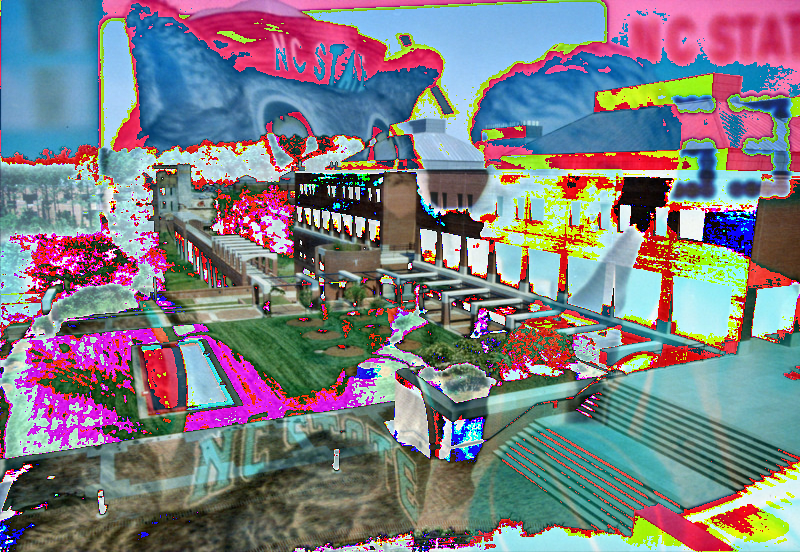

In [140]:
from PIL import Image
import requests
from io import BytesIO

# URL de la primera imagen
# url1 = "https://example.com/image1.jpg"
# # URL de la segunda imagen
# url2 = "https://example.com/image2.jpg"

# Obtener las imágenes desde las URL
response1 = requests.get(url1)
img1 = Image.open(BytesIO(response1.content))
response2 = requests.get(url2)
img2 = Image.open(BytesIO(response2.content))

# Asegurarse que las imágenes sean del mismo tamaño
if img1.size != img2.size:
    img2 = img2.resize(img1.size)

# Convertir las imágenes en matrices numpy para poder realizar operaciones
arr1 = np.array(img1)
arr2 = np.array(img2)

# Restar las dos matrices
result_arr = arr1 - arr2

# Convertir la matriz de resultados en una imagen y guardarla
result_img = Image.fromarray(result_arr.astype('uint8'))
result_img.show()
#result_img.save("result.jpg")